In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import scipy.stats
import sys
sys.path.append("../main/")
from double_t import EM
import pars_mf_model

plt.style.use('dark_background')

In [4]:
path_order = os.path.abspath("../data/energia/LOB_ottobre21/LOB_ottobre21/")
path_message = os.path.abspath("../data/energia/order/best_matching.csv")
data = MF.load_data(path_order + "\\", path_message)

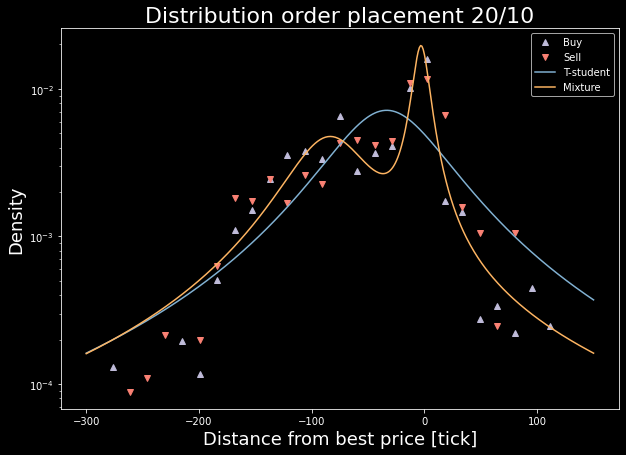

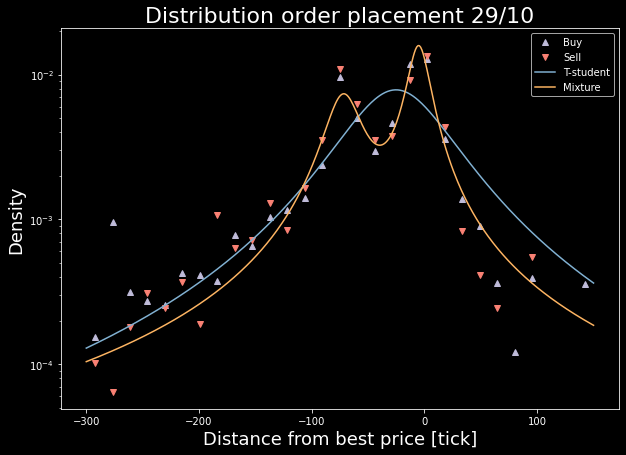

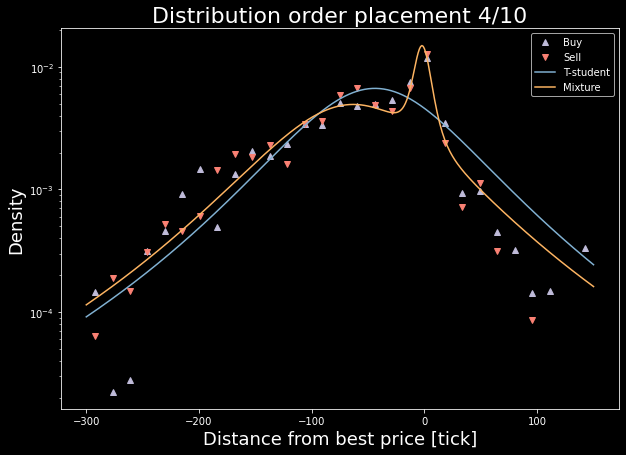

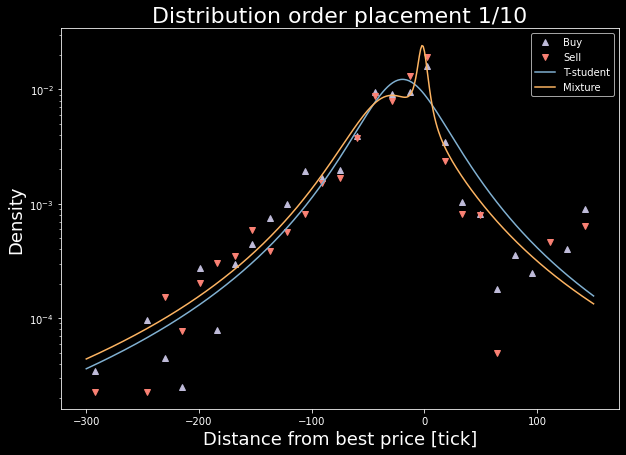

In [7]:
# Plot the distribution of the limit order placement as a function of the
# distance from the same side best price for 4 different trading days
days = [20, 29, 4, 1]

for i,dd in enumerate(days):
    ax, fig = plt.subplots(1,1, figsize = (10,7))
    new_df = data[data["Datetime"].dt.day == dd]
    new_df.reset_index(drop = True, inplace = True)
    
    # resample the distribution according to the weight of each data
    # see the article from MF for reference
    ask, bid = pars_mf_model.weighted_distance(new_df, n_resample = 50_000)
    xx = np.linspace(-300 , 150, 30)
    
    # plot histogram
    n_b, bins_b, _ = plt.hist(bid, density = True, bins = xx, alpha = 0)
    n_a, bins_a, _ = plt.hist(ask, density = True, bins = xx, alpha = 0)
    x_a = (bins_a[1:] + bins_a[:-1]) / 2
    x_b = (bins_b[1:] + bins_b[:-1]) / 2
    plt.plot(x_b, n_b, ls= "", marker = "^", label = "Buy")
    plt.plot(x_a, n_a, ls= "", marker = "v", label = "Sell")
    
    # fit a t-student distribution
    xx = np.linspace(-300,150,400)
    df, l, s = scipy.stats.t.fit(bid)
    plt.plot(xx, scipy.stats.t.pdf(xx, df, l, s), label=f"T-student")
    
    # fit a t_mixture model using the EM algorithm 
    # for the algorithm to work a initial guess for the parameters
    # must be given
    guess = (5, 3, -20, 5, 40, 5, 0.5)
    res = EM(guess, bid, iterations = 100)
    bi_t = pars_mf_model.double_t(*res)
    plt.plot(xx, bi_t.pdf(xx), label="Mixture")

    plt.title(f"Distribution order placement {dd}/10", fontsize = 22)
    plt.xlabel("Distance from best price [tick]", fontsize = 18)
    plt.ylabel("Density", fontsize = 18)
    plt.yscale("log")
    plt.legend()
    plt.show()